-------------------------------------
> ***Name:*** Mubanga Nsofu <br>
> ***Learner Id:*** 149050 <br>
> ***Course:*** BAN6440 (Machine Learning for Analytics) <br>
> ***Module 6 Assignment:*** Otomoto Marketing Segmentation Model Optimization <br>
> ***Lecturer:*** Professor Bucciarelli <br>
> ***Institution:*** Nexford University <br>
> ***Date:*** 15th December 2024

-------------------------------------------
> ***Introduction*** <br>

This assignment aims to enhance marketing segmentation for Otomoto by developing and optimizing an Artificial Neural Network (ANN) for predicting customer churn. Initially, a baseline model utilizes SMOTE (Synthetic Minority Oversampling Technique) to address class imbalance; however, the optimized model incorporates several advanced techniques, including undersampling to balance class sizes, feature scaling through StandardScaler, bias initialization to better reflect class imbalance, dropout regularization to mitigate overfitting, and early stopping to improve training efficiency. 

The efficacy of both models is evaluated using metrics such as Accuracy, Precision, Recall, F1-Score, and AUC-ROC, alongside visual aids like Training and Validation Loss graphs and ROC Curves. The research ultimately seeks to ascertain whether the enhancements in the optimized model result in superior churn prediction performance, thereby providing a more robust solution to the challenges of class imbalance and overfitting.

---------------------------
> ***Import libraries needed for the task***

In [17]:
#------------------- LOAD LIBRARIES REQUIRED--------------------------------------------------------------#

# TensorFlow and Keras: For building, training, and evaluating the Artificial Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential  # To create a linear stack of layers for the ANN
from tensorflow.keras.layers import Dense, Dropout  # Dense: Fully connected layers, Dropout: Prevents overfitting
from tensorflow.keras.optimizers import Adam  # Adam: Optimizer for training the model
from tensorflow.keras.callbacks import EarlyStopping  # EarlyStopping: Stops training when validation loss stops improving

# Scikit-learn: For data preprocessing, model evaluation, and metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,  # Metrics for model evaluation
                             roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix)  # ROC and Precision-Recall curves
from sklearn.model_selection import train_test_split  # Splits the dataset into training and testing sets
from sklearn.preprocessing import StandardScaler, LabelEncoder  # StandardScaler: Feature scaling, LabelEncoder: Encoding categorical variables
from sklearn.utils import resample, shuffle  # Resample: Undersampling/oversampling, Shuffle: Randomizes data

# imbalanced-learn: For handling class imbalance
from imblearn.over_sampling import SMOTE  # SMOTE: Synthetic Minority Oversampling Technique for balancing classes

# Visualization libraries
import matplotlib.pyplot as plt  # For creating static plots
import seaborn as sns  # For creating attractive and informative statistical graphics

# General-purpose libraries
import numpy as np  # For numerical operations and handling arrays
import pandas as pd  # For data manipulation and analysis


----------------------------------
> ***Load and prepare the dataset***

In [18]:
# ----------------------------- Data Preparation ----------------------------- #
# Load and clean dataset
dataset = pd.read_csv('teleconnect.csv')
dataset = dataset.dropna()
dataset = dataset.drop(dataset.index[(dataset["TotalCharges"] == " ")], axis=0)
dataset['TotalCharges'] = dataset.TotalCharges.astype(float)

# Encode categorical features
categorical_features = dataset.drop(['customerID', 'TotalCharges', 'MonthlyCharges', 'SeniorCitizen', 'tenure'], axis=1)
label_encoder = LabelEncoder()
dataset_category = categorical_features.apply(label_encoder.fit_transform)

# Merge numeric and encoded features
previously_dropped_features = dataset[['customerID', 'TotalCharges', 'MonthlyCharges', 'SeniorCitizen', 'tenure']]
final_dataset = pd.merge(previously_dropped_features, dataset_category, left_index=True, right_index=True)

# Drop customerID and prepare features
final_dataset = final_dataset.drop(['customerID'], axis=1)
X = final_dataset.drop(['Churn'], axis=1)
Y = final_dataset['Churn']


------------------------
> ***Split the dataset into training and test sets***

In [19]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.75, stratify=Y, random_state=42)


----------------------------------
> In this section we first recreate the ANN which we call the Base Model.
> One of the key observations is the baseline ANN model does not include any data scaling, drop out and early stopping
> The key plus is simplicity of the ANN model. 

In [20]:
# ----------------------------- Baseline Model: SMOTE without Scaling ----------------------------- #
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

def build_base_model():
    model = Sequential([
        Dense(19, input_shape=(x_train_smote.shape[1],), activation='relu'),
        Dense(15, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])
    return model


In [21]:
# Train the base model
base_model = build_base_model()
history_base = base_model.fit(x_train_smote, y_train_smote, epochs=50, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50


C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4878 - auc_2: 0.5308 - loss: 6.9976 - precision_2: 0.4582 - recall_2: 0.2155 - val_accuracy: 0.7309 - val_auc_2: 0.8039 - val_loss: 0.4994 - val_precision_2: 0.4957 - val_recall_2: 0.7345
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7194 - auc_2: 0.7806 - loss: 0.5981 - precision_2: 0.6894 - recall_2: 0.7918 - val_accuracy: 0.5859 - val_auc_2: 0.7384 - val_loss: 0.7320 - val_precision_2: 0.3827 - val_recall_2: 0.9122
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7235 - auc_2: 0.7859 - loss: 0.6353 - precision_2: 0.6955 - recall_2: 0.7852 - val_accuracy: 0.7480 - val_auc_2: 0.8051 - val_loss: 0.5072 - val_precision_2: 0.5208 - val_recall_2: 0.6445
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7372 - auc_2: 0.8025 - loss: 0.5885 - precision_2: 0.7121 - recall_2: 0.7940 - val_accuracy: 0.4915 - val_auc_2: 0.6370 - val_loss: 1.5496 - val_precision_2: 0.3381 - val_recall_2: 0.

In [23]:
base_model.summary()

Model: "sequential_2"
┌──────────────────────────────────────┬─────────────────────────────┬─────────────────┐
│ Layer (type)                         │ Output Shape                │         Param # │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 19)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

> The model has 4 dense layers with 851 trainable parameters, and 1704 optimizer parameters as shown above

In [24]:
# Evaluate baseline model
y_pred_base = base_model.predict(x_test).flatten()
y_pred_base_binary = (y_pred_base >= 0.5).astype(int)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


---------------------------------------
> New Optimised Model Implements Undersampling (better performance than SMOTE), Bias Initialization which helps the model start with a better initial loss value when dealing with class imbalance. Scaling is also introduced to ensure better ANN performance.

In [25]:
# ----------------------------- New Optimised Model: Undersampling (Instead of SMOTE) with Scaling ----------------------------- #
x_majority = x_train[y_train == 0]
y_majority = y_train[y_train == 0]
x_minority = x_train[y_train == 1]
y_minority = y_train[y_train == 1]

x_majority_undersampled, y_majority_undersampled = resample(
    x_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=42
)

x_train_undersampled = pd.concat([x_majority_undersampled, x_minority])
y_train_undersampled = pd.concat([y_majority_undersampled, y_minority])

x_train_undersampled, y_train_undersampled = shuffle(
    x_train_undersampled, y_train_undersampled, random_state=42
)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_undersampled)
x_test_scaled = scaler.transform(x_test)


In [26]:
# ----------------------Model definition with regularization implemented, initial bias also applied-------------------#
def build_new_model():
    initial_bias = tf.keras.initializers.Constant(np.log([len(y_train_undersampled[y_train_undersampled == 1]) / len(y_train_undersampled[y_train_undersampled == 0])]))
    model = Sequential([
        Dense(19, activation='relu', input_shape=(x_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(15, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid', bias_initializer=initial_bias)
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC()])
    return model


In [27]:
# ---------------Train the new model-----------------------------------
new_model = build_new_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history_new = new_model.fit(x_train_scaled, y_train_undersampled,
                            epochs=50,
                            validation_data=(x_test_scaled, y_test),
                            callbacks=[early_stopping],
                            verbose=1)


Epoch 1/50


C:\Users\Mubanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4745 - auc_3: 0.4624 - loss: 0.8378 - precision_3: 0.4605 - recall_3: 0.4449 - val_accuracy: 0.4118 - val_auc_3: 0.4630 - val_loss: 0.7057 - val_precision_3: 0.2528 - val_recall_3: 0.6210
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - auc_3: 0.5109 - loss: 0.7400 - precision_3: 0.5071 - recall_3: 0.5604 - val_accuracy: 0.3015 - val_auc_3: 0.4949 - val_loss: 0.7103 - val_precision_3: 0.2599 - val_recall_3: 0.8822
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5509 - auc_3: 0.5482 - loss: 0.7082 - precision_3: 0.5499 - recall_3: 0.6451 - val_accuracy: 0.3498 - val_auc_3: 0.5478 - val_loss: 0.7024 - val_precision_3: 0.2756 - val_recall_3: 0.8887
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5568 - auc_3: 0.5584 - loss: 0.6961 - precision_3: 0.5401 - recall_3: 0.6687 - val_accuracy: 0.3697 - val_auc_3: 0.5999 - val_loss: 0.7005 - val_precision_3: 0.2868 - val_recall_3: 0.9229
Epo

In [28]:
new_model.summary()

Model: "sequential_3"
┌──────────────────────────────────────┬─────────────────────────────┬─────────────────┐
│ Layer (type)                         │ Output Shape                │         Param # │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 19)                  │             380 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 19)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 15)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤

> The new model has a similar architecture as the old, but it includes dropout (for regularization) as shown above

In [29]:

#--------------------- Evaluate new model--------------------------------------#
y_pred_new = new_model.predict(x_test_scaled).flatten()
y_pred_new_binary = (y_pred_new >= 0.5).astype(int)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


----------------------------------------------------
> Compare Metrics of the Baseline Model and the New Model

In [30]:
#--------------baseline and new model metrics ----------------------#

def evaluate_model(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_proba)
    }

base_metrics = evaluate_model(y_test, y_pred_base_binary, y_pred_base)
new_metrics = evaluate_model(y_test, y_pred_new_binary, y_pred_new)

print("\nBase Model Metrics:")
print(base_metrics)

print("\nNew Model Metrics:")
print(new_metrics)



Base Model Metrics:
{'Accuracy': 0.6143344709897611, 'Precision': 0.3974732750242954, 'Recall': 0.8758029978586723, 'F1-Score': 0.5467914438502673, 'AUC-ROC': 0.7575249171914938}

New Model Metrics:
{'Accuracy': 0.6416382252559727, 'Precision': 0.41970443349753694, 'Recall': 0.9122055674518201, 'F1-Score': 0.5748987854251012, 'AUC-ROC': 0.8060887680648602}


> The metrics are better accross all the categories for the new model. This is further discussed at the end when the confuison matrix is analyzed

--------------------------------
 **Loss Comparison (Two Side-by-Side Plots)**

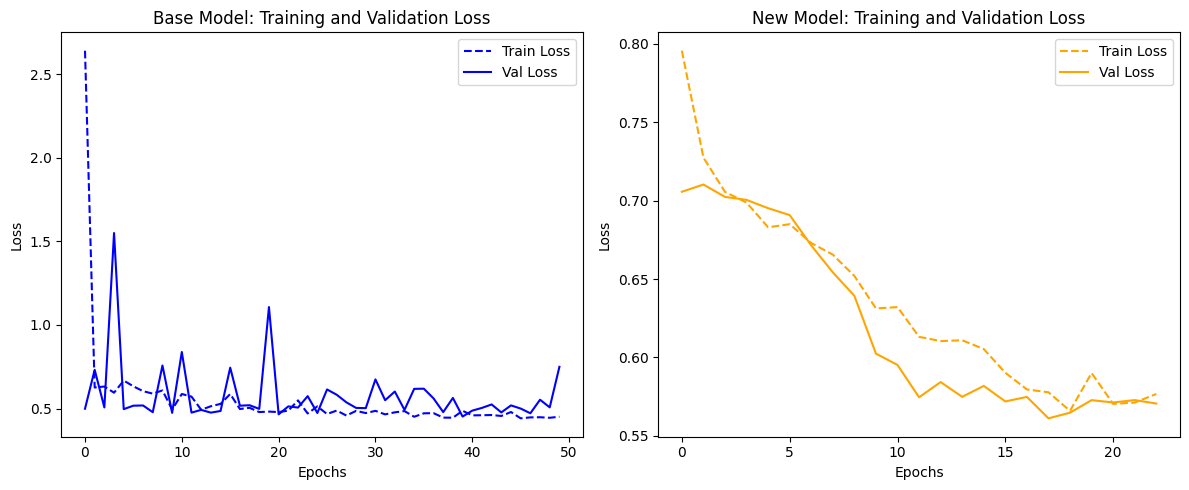

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Base Model Loss
ax[0].plot(history_base.history['loss'], label='Train Loss', linestyle='--', color='blue')
ax[0].plot(history_base.history['val_loss'], label='Val Loss', linestyle='-', color='blue')
ax[0].set_title('Base Model: Training and Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# New Model Loss
ax[1].plot(history_new.history['loss'], label='Train Loss', linestyle='--', color='orange')
ax[1].plot(history_new.history['val_loss'], label='Val Loss', linestyle='-', color='orange')
ax[1].set_title('New Model: Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

> The loss curves indicate that the base model demonstrates unstable training, as the loss fluctuates throughout the process. Additionally, the model exhibits poor generalisation, with the validation loss consistently remaining high. The absence of certain optimization processes in the model is contributing to these issues.

> The New Model post the optimisation show better behaved curves with improved validation loss performance and smoother training curves.


--------------------------------------
**ROC Curves**

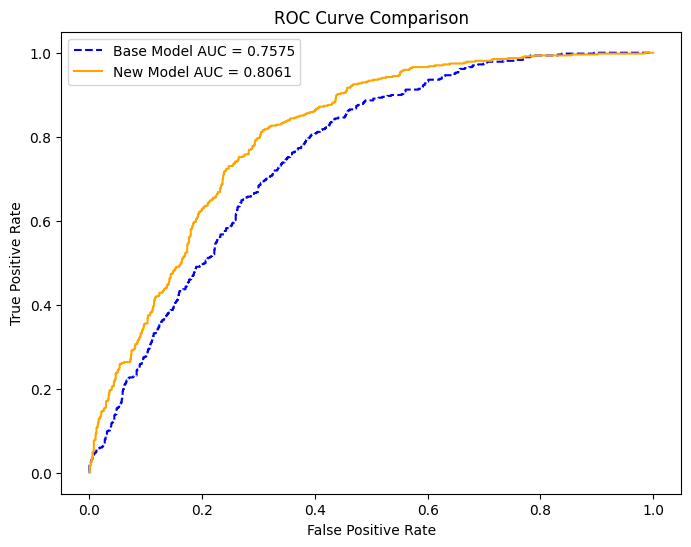

In [32]:
# ROC Curve
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_base)
fpr_new, tpr_new, _ = roc_curve(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Base Model AUC = {base_metrics["AUC-ROC"]:.4f}', linestyle='--', color='blue')
plt.plot(fpr_new, tpr_new, label=f'New Model AUC = {new_metrics["AUC-ROC"]:.4f}', linestyle='-', color='orange')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


> The New Model has better overall discriminatory power across many values

-----------------------
**Precision Recall Curve**

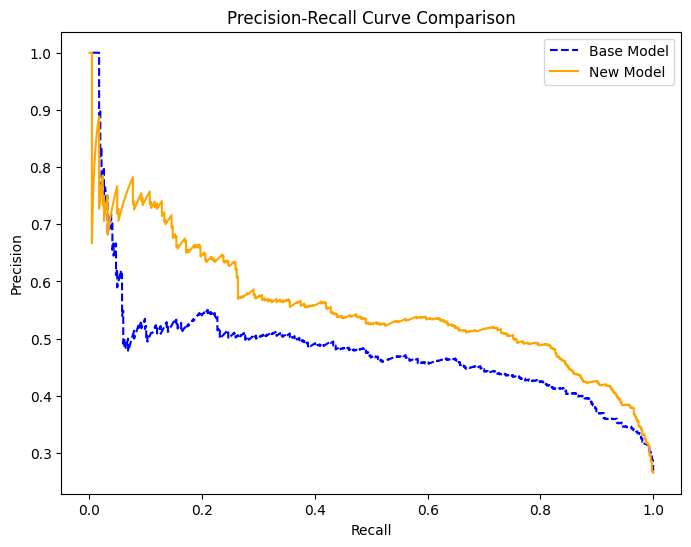

In [33]:
# Precision-Recall Curve
precision_base, recall_base, _ = precision_recall_curve(y_test, y_pred_base)
precision_new, recall_new, _ = precision_recall_curve(y_test, y_pred_new)

plt.figure(figsize=(8, 6))
plt.plot(recall_base, precision_base, label='Base Model', linestyle='--', color='blue')
plt.plot(recall_new, precision_new, label='New Model', linestyle='-', color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()

> The new model has a better recall (Sensitivity) performance, especially in the mid to high range, and this is critical in a Churn problem where losing a customer is more costly than having an unhappy customer. For this application, most of the churners are younger thus identifiying them (better recall performance) before they churn is very important.

> The new model is more suitable for Otomoto Marketing Segmentation, where minimising customer impact is paramount.



------------------------------
**Confusion Matrix**

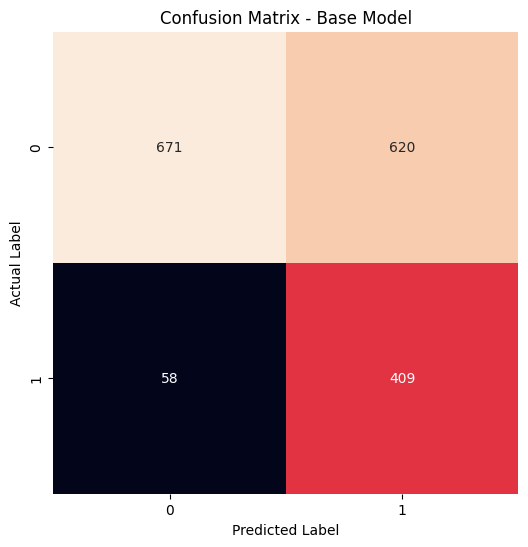

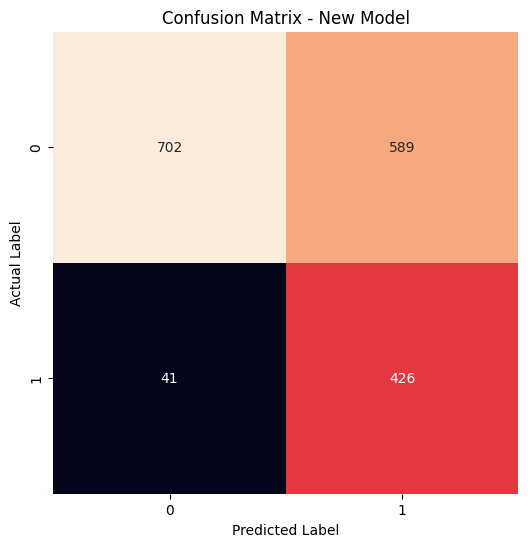

In [34]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", cbar=False)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred_base_binary, 'Confusion Matrix - Base Model')
plot_confusion_matrix(y_test, y_pred_new_binary, 'Confusion Matrix - New Model')


> What does each quadrant represent? <br>
***True Positive (TP):*** Correctly predicted churn.<br>
***True Negative (TN):*** Correctly predicted no churn. <br>
***False Positive (FP):*** Incorrectly predicted churn (when there was no churn). <br>
***False Negative (FN):*** Incorrectly predicted no churn (when there was churn). <br>

> ***Base Model:*** <br>

True Positives (TP): 409 <br>
True Negatives (TN): 671 <br>
False Positives (FP): 620 <br>
False Negatives (FN): 58 <br>

> ***New Model:*** <br>

True Positives (TP): 426 <br>
True Negatives (TN): 702 <br>
False Positives (FP): 589 <br>
False Negatives (FN): 41

> ***Cost of False Negatives:*** A false negative in churn prediction means Otomoto fails to identify a customer at risk of leaving, leading to lost revenue. The new model has fewer false negatives, with 41 compared to 58 in the base model.<br>

> ***Cost of False Positives:*** A false positive means Otomoto predicts a customer will churn when they actually won't. While this might lead to some wasted effort or unnecessary retention incentives, it's generally less costly than losing the customer altogether. The new model has lower false positives (589) compared to 620 for the base model. 

> Both metrics are better for the new model

***Additional Metrics*** <br>

> *Base Model* <br>

- Precision: TP / (TP + FP) = 409 / (409 + 620) = 0.397
- Recall: TP / (TP + FN) = 409 / (409 + 58) = 0.875
- Specificity: TN / (TN + FP) = 671 / (671 + 620) = 0.520
- F1-score: 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.397 * 0.875) / (0.397 + 0.875) = 0.544 <br>

> *New Model*

- Precision: TP / (TP + FP) = 426 / (426 + 589) = 0.420
- Recall: TP / (TP + FN) = 426 / (426 + 41) = 0.912
- Specificity: TN / (TN + FP) = 702 / (702 + 589) = 0.544
- F1-score: 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.420 * 0.912) / (0.420 + 0.912) = 0.571

> The new model shows improvement accross all the metrics

- Higher Recall: It captures a larger proportion of actual churners.
- Slightly Higher Precision: It has a marginally better rate of correct churn predictions among all positive predictions.
- Higher Specificity: It correctly identifies a slightly larger proportion of non-churners.
- Higher F1-score: It achieves a better balance between precision and recall. The new model has a higher F1-Score meaning it is doing a better job at both identifying churners and being accurate in predictions.


--------------------------------
> **References** <br>

> Tamanna. (2023). *Handling Imbalanced Datasets in Python: Methods and Procedures.* Medium. https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de

> Google. (2024). *Classification on imbalanced data.* TensorFlow Core. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

> Tang, T. (2023). *Class Imbalance Strategies — A Visual Guide with Code.* Towards Data Science. https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a


